In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


def show_image(image_list, label_list=None, cols=4, fig_w=18, fig_h=12, show_axis='on', debug=False):
    '''
    Utility function to display image list.
    '''
    if label_list is None:
        label_list = []
        label_found = False
    else:
        label_found = True

    n_img = len(image_list)
    if n_img < 1 and debug:
        print('No image to be shown'.format(n_img))
        pass

    rows = n_img // cols
    if rows == 0:
        rows = 1
    if rows * cols < n_img:
        rows += 1

    gs = gridspec.GridSpec(rows, cols)
    plt.close('all')
    plt.figure(figsize=(fig_w, fig_h))
    
    matplotlib.rcParams.update({'font.size': 14})
    
    for i, img in enumerate(image_list):
        #fig = plt.subplot(gs[i])
        plt.subplot(gs[i])
        if label_found:
            #fig.set_title(label_list[i], fontsize=10)
            plt.title(label_list[i])

        #fig.imshow(img, cmap='gray')
        #fig.axis(show_axis)
        plt.imshow(img, cmap="gray")
        plt.axis("on")
        

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)
    plt.show()
    

Can't find corners for ['calibration1.jpg', 'calibration4.jpg', 'calibration5.jpg']


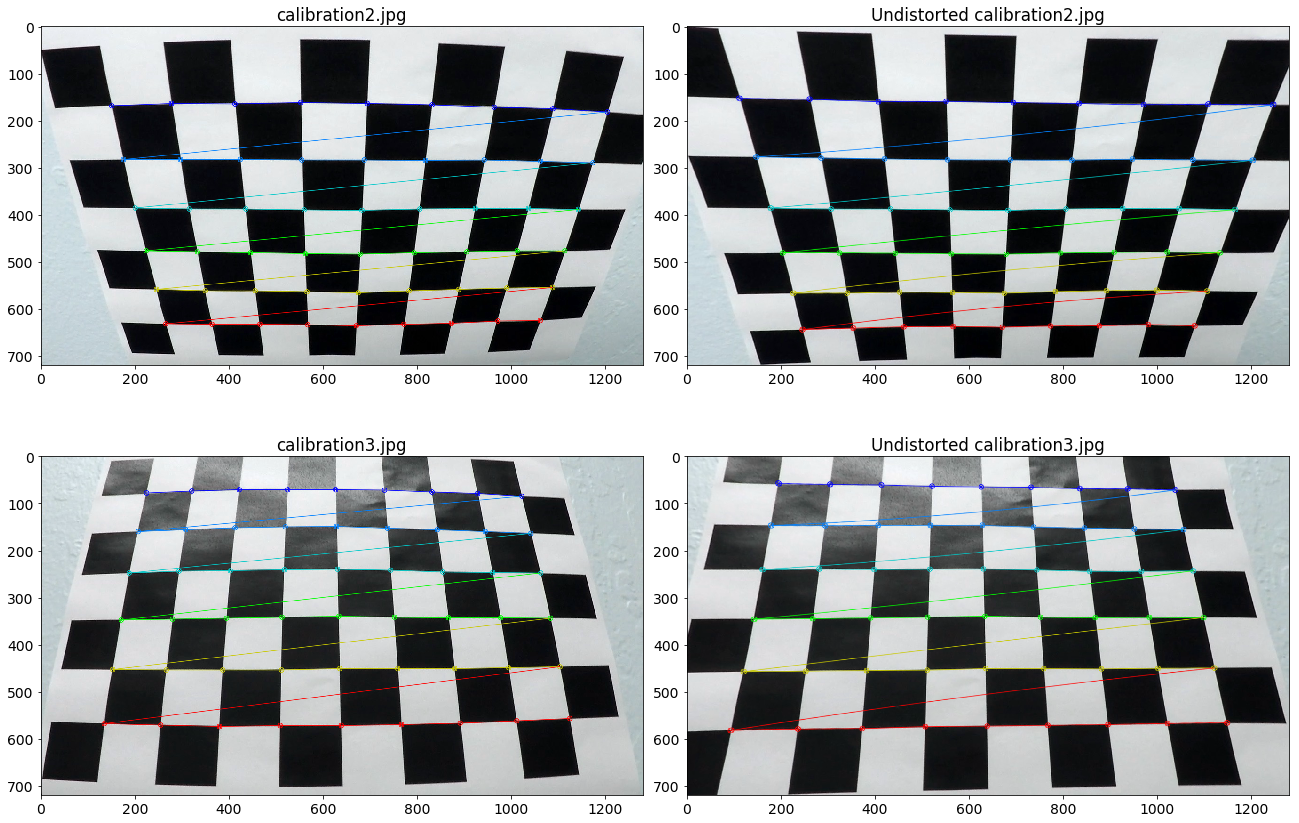

In [2]:
def calibrate_camera(show=False, debug=False):
    '''
    To calibrate camera base on chessboard images in calibration folder
    '''

    image_calib_list = []
    file_name_list = []

    for i in range(20):
        file_name = 'calibration' + str(i + 1) + '.jpg'
        img_read = cv2.imread('./camera_cal/' + file_name)
        image_calib_list.append(img_read)
        file_name_list.append(file_name)


    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane

    img_size = None

    img_show_list = []
    lbl_show_list = []
    
    img_corner_not_found_list = []
    
    for i, img_src in enumerate(image_calib_list):

        img_gray = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)
        calib_success, corners = cv2.findChessboardCorners(img_gray, (9, 6), None)

        if calib_success:
            objpoints.append(objp)
            imgpoints.append(corners)

            if img_size is None:
                img_size = (img_gray.shape[1], img_gray.shape[0])
                
            cv2.drawChessboardCorners(img_src, (9, 6), corners, calib_success)

            if show:
                img_show_list.append(img_src)
                lbl_show_list.append(file_name_list[i])
            
        else:
            img_corner_not_found_list.append("calibration" + str(i + 1) + ".jpg")
            

    calib_success, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    img_undist_list = []
    if calib_success:
        for img_src in img_show_list:            
            img_undist = cv2.undistort(img_src, matrix, distortion, None, matrix)
            img_undist_list.append(img_undist)
        
    if not calib_success and debug:
        print("Calibration is FAILED, objpoints:", len(objpoints), "imgpoints:", len(imgpoints))

    if debug and len(img_corner_not_found_list) > 0:
        print("Can't find corners for", img_corner_not_found_list)

    if show:
        
        show_image([img_show_list[0], img_undist_list[0],
                    img_show_list[1], img_undist_list[1]
                   ],
                   [lbl_show_list[0], 'Undistorted ' + lbl_show_list[0],
                    lbl_show_list[1], 'Undistorted ' + lbl_show_list[1]
                   ], cols=2)
                
    return matrix, distortion


g_matrix, g_distortion = calibrate_camera(show=True, debug=True)

Test images exploration, 2 straight lines, and 6 curvy lane lines.

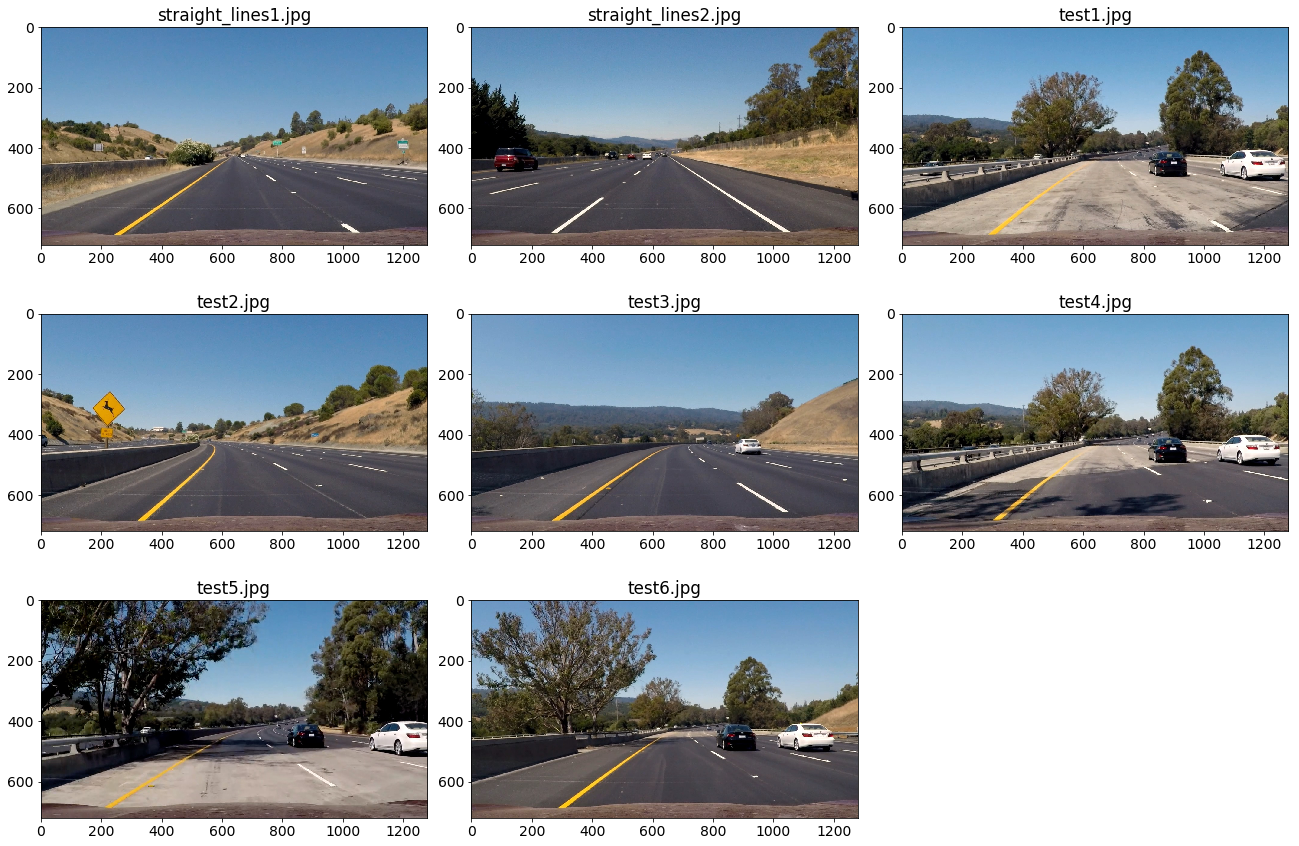

In [3]:
def load_test_image(show=False):
    image_list = []
    file_name_list = []
    files = os.listdir('test_images/')

    for f_name in files:
        if f_name.endswith('.jpg'):
            img = plt.imread('./test_images/' + f_name)
            image_list.append(img)
            file_name_list.append(f_name)
    if show:
        show_image(image_list, file_name_list, cols=3)
    return image_list, file_name_list


img_list, lbl_list = load_test_image(show=True)

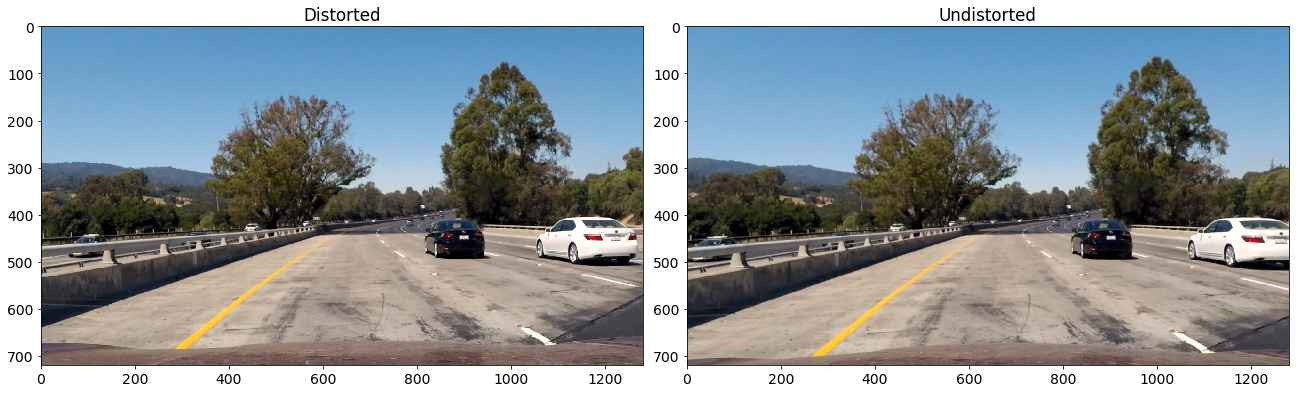

In [4]:
def undistort(img_src, matrix, distortion, show=False):
    img_undist = cv2.undistort(img_src, matrix, distortion, None, matrix)

    if show:
        show_image([img_src, img_undist], ['Distorted', 'Undistorted'], cols=2)

    return img_undist

img_ori = img_list[2]
img_undistorted = undistort(img_ori, g_matrix, g_distortion, show=True)

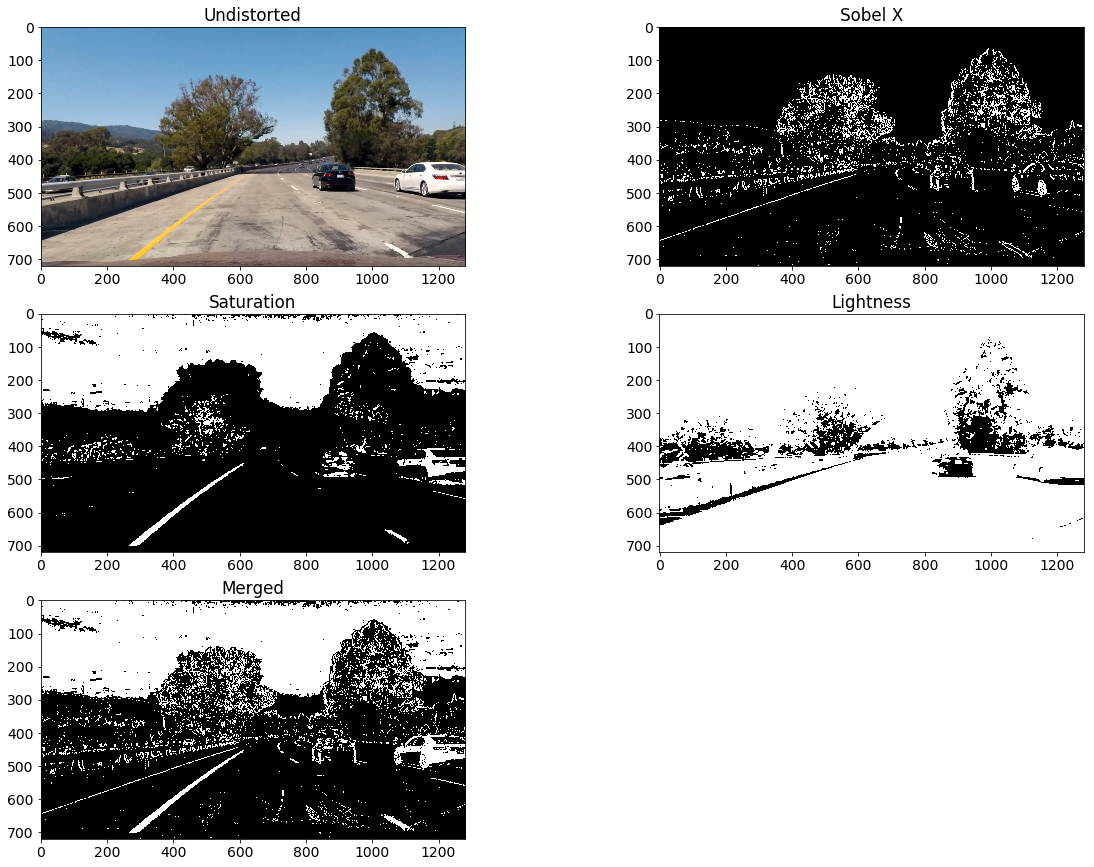

In [5]:
def color_transform(img_src, show=False):

    img_hls = cv2.cvtColor(img_src, cv2.COLOR_BGR2HLS).astype(np.float)

    #Lightness Filter
    ch_l = img_hls[:, :, 1]
    img_lgh = np.zeros_like(ch_l)
    img_lgh[(ch_l >= 40) & (ch_l <= 255)] = 1

    #Saturation Filter
    ch_s = img_hls[:, :, 2]
    img_sat = np.zeros_like(ch_s)
    img_sat[(ch_s >= 120) & (ch_s <= 255)] = 1

    #Sobel X Filter
    kernel_size=9
    #img_gauss = cv2.GaussianBlur(img_src, (kernel_size, kernel_size), 0)
    #img_gray = cv2.cvtColor(img_gauss, cv2.COLOR_BGR2GRAY)
    img_gray = img_hls[:, :, 1]
    
    sobelx_abs = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0))
    
    sobelx_scal = np.uint8(255 * sobelx_abs / np.max(sobelx_abs))
    img_sobel = np.zeros_like(sobelx_scal)
    img_sobel[(sobelx_scal >= 20) & (sobelx_scal <= 255)] = 1

    #merged_filter = 255 * np.dstack((img_sobel, img_sat, img_lgh)).astype(np.uint8)
    img_filter = np.zeros_like(img_sobel)
    img_filter[((img_lgh == 1) & (img_sat == 1) | (img_sobel == 1))] = 1
    img_filter = 255 * np.dstack((img_filter, img_filter, img_filter)).astype(np.uint8)

    if show:
        show_image([img_src, img_sobel, img_sat, img_lgh, img_filter], 
                   ['Undistorted', 'Sobel X', 'Saturation', 'Lightness', 'Merged'], cols=2)

    return img_filter


img_filtered = color_transform(img_undistorted, show=True)

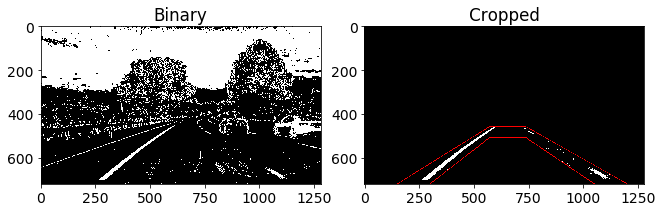

In [6]:
def crop(img_src, show=False, vertices=None):

    if vertices is None:
        x_tl = 575  # upper left
        x_bl = 150  # bottom left
        
        x_tr = 738 #728  # upper right
        x_br = 1205  # 1155  # bottom right

        y_t = 457  # y upper
        y_b = 720  # y lower

        x_offset = 150
        y_offset = 50
        vertices = np.array([[x_bl, y_b], [x_tl, y_t], [x_tr, y_t], [x_br, y_b]])
        vertices2 = np.array([[x_bl+x_offset, y_b], [x_tl, y_t+y_offset], [x_tr, y_t+y_offset], [x_br-x_offset, y_b]])

    # draw region
    mask = np.zeros_like(img_src)
    
    if len(img_src.shape) > 2:
        ch_count = img_src.shape[2]
        ignore_mask_color = (255,) * ch_count
        ignore_mask_color2 = (0,) * ch_count
    else:
        ignore_mask_color = 255
        ignore_mask_color2 = 0

    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    cv2.fillPoly(mask, [vertices2], ignore_mask_color2)
    img_crop = cv2.bitwise_and(img_src, mask)
    img_crop_line = img_crop.copy()
    cv2.polylines(img_crop_line, [vertices], True, (255, 0, 0), thickness=2)
    cv2.polylines(img_crop_line, [vertices2], True, (255, 0, 0), thickness=2)

    if show:
        show_image([img_src, img_crop_line], ['Binary', 'Cropped'])

    return img_crop


img_cropped = crop(img_filtered, show=True)

Gradien `g_M` variable, gradient inverse variable `g_M_inverse`, and rectangle points `g_rect_points` are pre-calculated once at 7th code cell at function `get_transform_m()`, to be used later within pipeline function`. 

In [7]:
def get_tranform_m(debug=False):
    y_t = 457
    y_b = 720

    x_tl = 586  # x_tl + 6
    x_tr = 692  # x_tr - 8

    x_bl = 220  # x_bl + 30
    x_br = 1100  # x_br - 30

    top_left_src = np.array([x_tl, y_t])
    top_right_src = np.array([x_tr, y_t])

    bottom_left_src = np.array([x_bl, y_b])
    bottom_right_src = np.array([x_br, y_b])

    offset = (x_tl - x_tr + x_br - x_bl) // 4

    top_left_dst = np.array([x_tl - offset, 0])
    top_right_dst = np.array([x_tr + offset, 0])

    bottom_left_dst = np.array([x_bl + offset, y_b])
    bottom_right_dst = np.array([x_br + - offset, y_b])

    reg_src = np.float32([top_left_src, top_right_src, bottom_right_src, bottom_left_src])
    reg_dst = np.float32([top_left_dst, top_right_dst, bottom_right_dst, bottom_left_dst])
    
    if debug:
        print('offset:', offset, 'x top-left:', x_tl, 'x bottom-left:', x_bl, 'x top-right:', x_tr, 'x bottom-right:', x_br)
        print('Source:', reg_src)
        print('Destination:', reg_dst)
    m = cv2.getPerspectiveTransform(reg_src, reg_dst)
    m_inv = cv2.getPerspectiveTransform(reg_dst, reg_src)

    return m, m_inv, [tuple(top_left_dst), tuple(bottom_right_dst)]


g_M, g_M_inv, g_rect_points = get_tranform_m(debug=True)

offset: 193 x top-left: 586 x bottom-left: 220 x top-right: 692 x bottom-right: 1100
Source: [[  586.   457.]
 [  692.   457.]
 [ 1100.   720.]
 [  220.   720.]]
Destination: [[ 393.    0.]
 [ 885.    0.]
 [ 907.  720.]
 [ 413.  720.]]


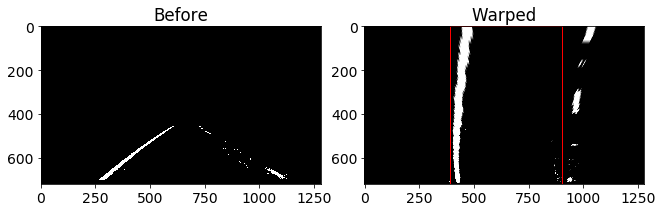

In [15]:
def warp(img_src, m, rectangle_points=None, show=False):

    img_size = (img_src.shape[1], img_src.shape[0])
    img_warp = cv2.warpPerspective(img_src, m, img_size, flags=cv2.INTER_LINEAR)    

    if rectangle_points is not None:
        img_warp_line = img_warp.copy()
        cv2.rectangle(img_warp_line, rectangle_points[0], rectangle_points[1], (255, 0, 0), thickness=4)
        if show:
            show_image([img_src, img_warp_line], ['Before', 'Warped'])

    elif show:
        show_image([img_src, img_warp], ['Before', 'Warped'])

    return img_warp, img_warp_line


img_warped, img_warped_line = warp(img_cropped, g_M, rectangle_points=g_rect_points, show=True)


Histogram base left: 408 right: 951


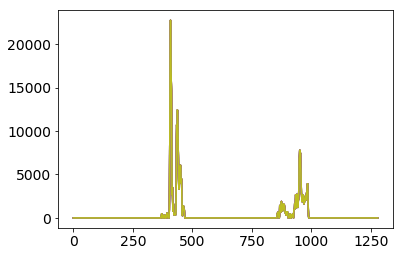

Plot shape x-fit left 459.617615351 right: 1014.84119639 Plot-y: 100.0
Points shape left (1, 720, 2) right: (1, 720, 2) Plot-y: (720,)
Shape img: (720, 1280) img_window: (720, 1280, 3) img_result: (720, 1280, 3)


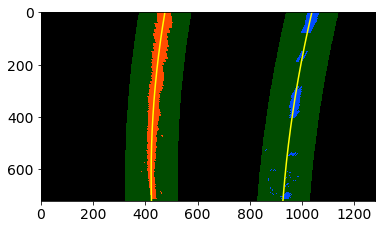

In [9]:
def line_detection(img_src, show=False, debug=False):

    img_h = img_src.shape[0]
    img_stack = np.dstack((img_src, img_src, img_src)) * 255

    histogram = np.sum(img_stack[img_stack.shape[0]//2:, :], axis=0)
    mid_point = np.int(histogram.shape[0]/2)
    x_base_left = np.argmax(histogram[:mid_point], axis=0)[0]
    x_base_right = np.argmax(histogram[mid_point:], axis=0)[0] + mid_point

    if debug:
        print("Histogram base left:", x_base_left, "right:", x_base_right)
        plt.plot(histogram)
        plt.show()

    img = img_src[:, :, -1]
    

    #sliding
    n_slicing_windows = 9
    window_height = np.int(img_h / n_slicing_windows)

    #Non-zero pix in the image
    non_zero = img.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])

    x_current_left = x_base_left
    x_current_right = x_base_right

    margin = 100
    min_pix = 50

    left_lane_inds = []
    right_lane_inds = []

    for window in range(n_slicing_windows):
        win_y_low = img_h - (window + 1) * window_height
        win_y_high = img_h - window * window_height

        win_x_left_low = x_current_left - margin
        win_x_left_high = x_current_left + margin

        win_x_right_low = x_current_right - margin
        win_x_right_high = x_current_right + margin

        #Draw sliding window box
        # cv2.rectangle(img, (win_x_left_low, win_y_low), (win_x_left_high, win_y_high), (0, 255, 0), thickness=4)
        # cv2.rectangle(img, (win_x_right_low, win_y_low), (win_x_right_high, win_y_high), (0, 0, 255), thickness=4)

        good_left_inds = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_x_left_low) & (non_zero_x < win_x_left_high)).nonzero()[0]
        good_right_inds = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_x_right_low) & (non_zero_x < win_x_right_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #if debug:
        #    print("Img shape", img.shape, "Good left:", good_left_inds.shape, "Good right:", good_right_inds.shape)

        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > min_pix:
            x_current_left = np.int(np.mean(non_zero_x[good_left_inds]))

        if len(good_right_inds) > min_pix:
            x_current_right = np.int(np.mean(non_zero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = non_zero_x[left_lane_inds]
    lefty = non_zero_y[left_lane_inds]
    rightx = non_zero_x[right_lane_inds]
    righty = non_zero_y[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    if debug:
        print('Plot shape x-fit left', left_fitx[100], 'right:', right_fitx[100], 'Plot-y:', ploty[100])

    # Create an image to draw on and an image to show the selection window
    # Color in left and right line pixels
    img_out = np.dstack((img, img, img)) * 255
    img_out[non_zero_y[left_lane_inds], non_zero_x[left_lane_inds]] = [255, 0, 0]  #Red
    img_out[non_zero_y[right_lane_inds], non_zero_x[right_lane_inds]] = [0, 0, 255] #Blue

    #Recast the x and y points into usable format for cv2.fillPoly
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    img_window = np.zeros_like(img_out)
    #cv2.fillPoly(img_window, np.int_([pts]), (0, 255, 0))
    #cv2.polylines(img_window, [left_fitx, right_fitx], (0, 255, 0), thickness=3)
    
    if debug:
        print('Points shape left', pts_left.shape, 'right:', pts_right.shape, 'Plot-y:', ploty.shape)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(img_window, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(img_window, np.int_([right_line_pts]), (0, 255, 0))
    img_result = cv2.addWeighted(img_out, 1, img_window, 0.3, 0)

    if debug:
        print('Shape img:', img.shape, 'img_window:', img_window.shape, 'img_result:', img_result.shape)

    if show:        
        plt.imshow(img_result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()

    return left_fitx, right_fitx, ploty


fit_x_left, fit_x_right, plot_y = line_detection(img_warped, show=True, debug=True)

In [10]:
def calc_radius_curvature(ploty, leftx, rightx, debug=False):

    y_eval = np.max(ploty)
    #left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    #right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    curve_rad = (left_curverad + right_curverad) / 2
    
    # Calculate center
    #center_dist_in_px = (rightx[700] + leftx[700] - 1280) / 2
    center_dist_in_px = (1280 - rightx[700] - leftx[700]) / 2
    center_dist = center_dist_in_px * xm_per_pix
    
    if debug:
        print('Curvature {:.2f}m Left: {:.2f}m, Right:{:.2f}m'.format(curve_rad, left_curverad, right_curverad))
        print('Center distance {:.2f}m, {:.0f}px, r:{:.2f} l:{:.2f}'.format(center_dist, center_dist_in_px, rightx[719], leftx[719]))
    
    return curve_rad, center_dist


calc_radius_curvature(plot_y, fit_x_left, fit_x_right, debug=True)

Curvature 1353.19m Left: 1206.77m, Right:1499.62m
Center distance -0.19m, -36px, r:926.63 l:424.02


(1353.1938830532843, -0.18936585843917991)

In [11]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self):

        self.detected = False # was the line detected in the last iteration?

        self.recent_xfitted = []  # x values of the last n fits of the line
        self.bestx = None  #average x values of the fitted line over the last n iterations
        self.best_fit = None #polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])]  #polynomial coefficients for the most recent fit

        self.radius_of_curvature = None #radius of curvature of the line in some units
        self.line_base_pos = None  #distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float') #difference in fit coefficients between last and new fits

        self.allx = None #x values for detected line pixels
        self.ally = None #y values for detected line pixels

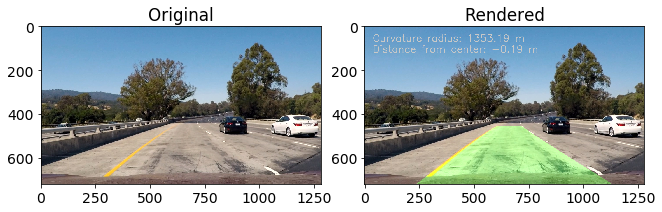

In [12]:
def render_lane_lines(img_warped, left_fitx, right_fitx, ploty, img_src, m_inv, undist, show=False):
    color_warp = np.zeros_like(img_warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)

    newwarp = cv2.warpPerspective(color_warp, m_inv, (img_src.shape[1], img_src.shape[0]))
    # Combine the result with the original image
    img_unwrap = cv2.addWeighted(img_src, 1, newwarp, 0.3, 0)

    # Render text
    curve_rad, center_dist = calc_radius_curvature(ploty, left_fitx, right_fitx)

    text1 = "Curvature radius: {:0.2f} m".format(curve_rad)
    font_color = (200, 200, 200)

    font_face = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_unwrap, text1, (40, 70), font_face, 1.5, font_color, 2, cv2.LINE_AA)

    text2 = "Distance from center: {:0.2f} m".format(center_dist)
    cv2.putText(img_unwrap, text2, (40, 120), font_face, 1.5, font_color, 2, cv2.LINE_AA)

    if show:
        show_image([img_src, img_unwrap], ['Original', 'Rendered'])

    return img_unwrap


img_unwrap = render_lane_lines(img_warped,  fit_x_left, fit_x_right, plot_y, img_ori, g_M_inv, img_undistorted, show=True)

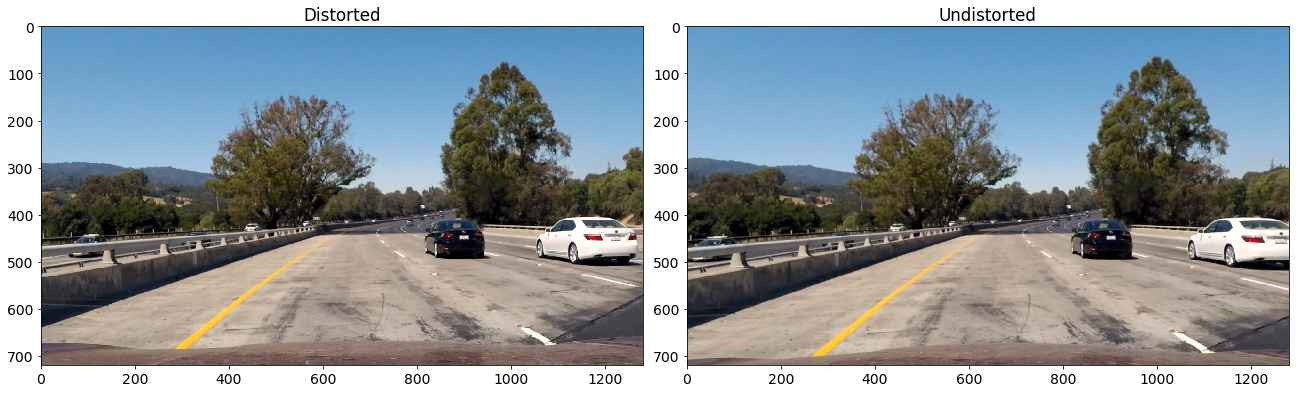

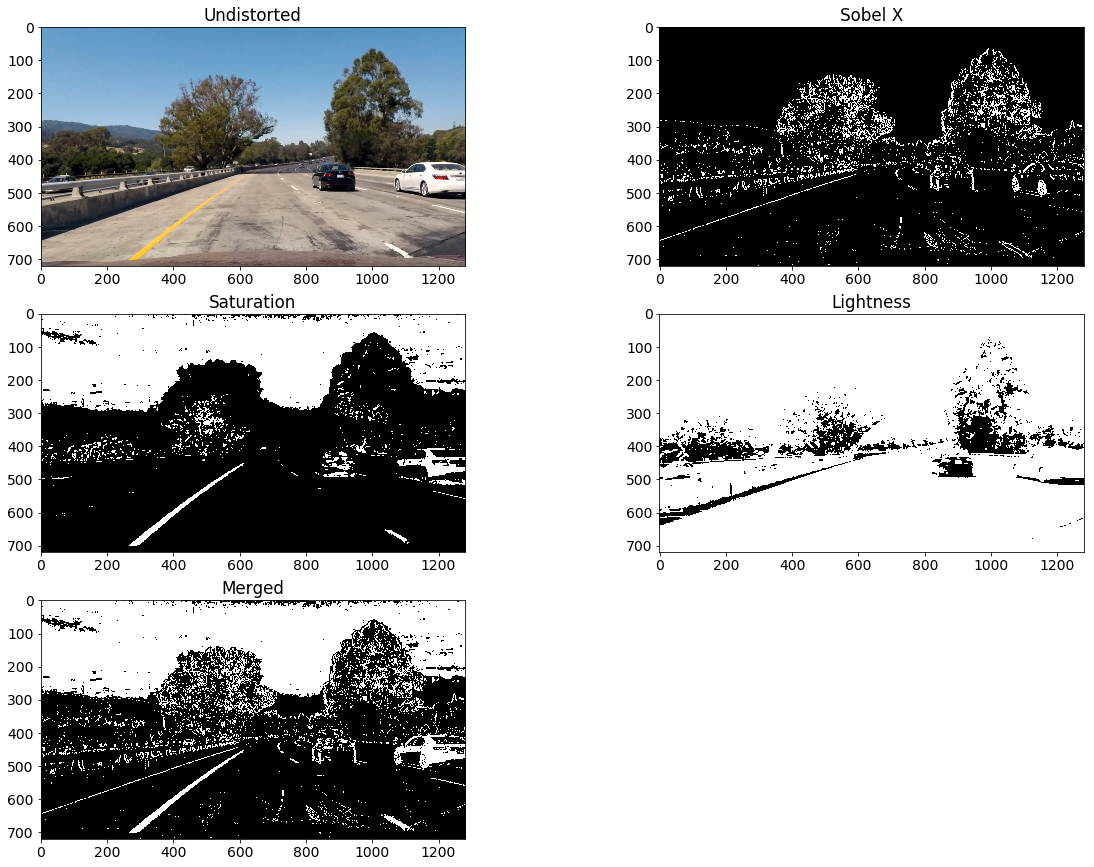

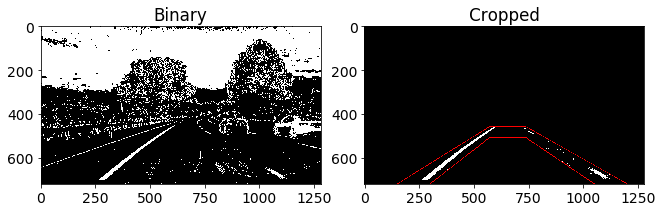

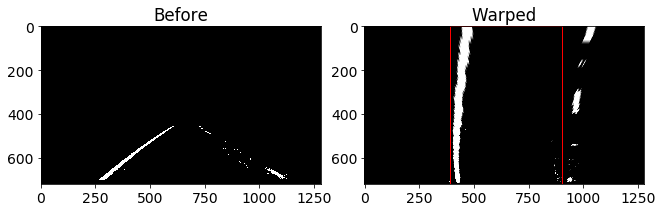

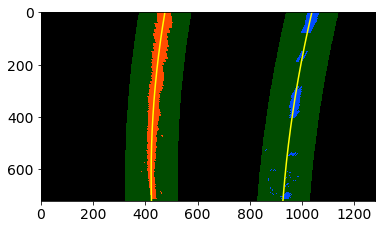

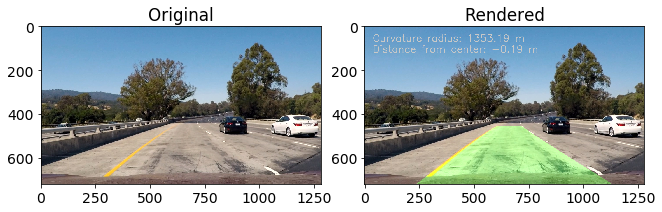

array([[[254, 233, 216],
        [245, 238, 232],
        [196, 205, 212],
        ..., 
        [ 16,  35,  52],
        [ 20,  37,  53],
        [ 32,  48,  63]],

       [[245, 238, 232],
        [188, 193, 197],
        [137, 158, 175],
        ..., 
        [ 74, 108, 135],
        [ 47,  77, 103],
        [  4,  34,  60]],

       [[193, 202, 209],
        [134, 157, 173],
        [115, 154, 183],
        ..., 
        [ 95, 144, 184],
        [ 89, 137, 177],
        [ 52,  97, 136]],

       ..., 
       [[141, 131, 129],
        [132, 121, 119],
        [114, 100,  97],
        ..., 
        [ 99,  80,  74],
        [ 99,  80,  74],
        [113,  94,  88]],

       [[164, 154, 152],
        [133, 122, 120],
        [120, 106, 103],
        ..., 
        [107,  88,  82],
        [109,  90,  84],
        [111,  92,  86]],

       [[189, 179, 177],
        [135, 125, 123],
        [128, 117, 113],
        ..., 
        [ 97,  78,  72],
        [ 95,  76,  70],
        [ 73,  54,

In [16]:
def process_image(img_src, show=False):
    img_undistort = undistort(img_src, g_matrix, g_distortion, show=show)
    img_trf_color = color_transform(img_undistort, show=show)
    img_crop = crop(img_trf_color, show=show)
    
    img_warp, img_warp_line = warp(img_crop, g_M, rectangle_points=g_rect_points, show=show)
    
    fitx_l, fitx_r, plot_y = line_detection(img_warp, show=show)
    img_result = render_lane_lines(img_warp, fitx_l, fitx_r, plot_y, img_src, g_M_inv, img_undistort, show=show)
    
    return img_result


process_image(img_list[2], show=True)

In [17]:
#line_l = Line()
#line_r = Line()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')

video_proc = video_input.fl_image(process_image)
%time video_proc.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:25<00:00,  6.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 26s
